In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans

import os

In [3]:
num_clusters = 6

In [4]:
def extract_lab_features(image):
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    if L_non_black.size == 0:
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [5]:
filenames = []
l_values = []
a_values = []
b_values = []

In [6]:
base_image_path = '../dataset_original/all/'
images = os.listdir(base_image_path)

In [7]:
for image_file in tqdm(images, desc="Parsing images"):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        full_image_path = os.path.join(base_image_path, image_file)
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Error: Unable to read image at {full_image_path}")
            continue
        
        l_mean, a_mean, b_mean = extract_lab_features(image)
        
        filenames.append(full_image_path)
        l_values.append(l_mean)
        a_values.append(a_mean)
        b_values.append(b_mean)


Parsing images: 100%|██████████| 1066/1066 [00:04<00:00, 237.24it/s]


In [8]:
df = pd.DataFrame({
    'filename': filenames,
    'L': l_values,
    'A': a_values,
    'B': b_values
})

In [9]:
overall_L_mean = df['L'].mean()

In [10]:
X = df[['A', 'B']]
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
print(df)

                                               filename           L  \
0     ../dataset_original/all/CC_1000_jpg.rf.6f593c5...  126.557500   
1     ../dataset_original/all/CC_1001_jpg.rf.be542e9...  130.647988   
2     ../dataset_original/all/CC_1002_jpg.rf.fe2526e...  128.956030   
3     ../dataset_original/all/CC_1003_jpg.rf.bf38690...  154.055896   
4     ../dataset_original/all/CC_1004_jpg.rf.0cdcd2a...  133.910317   
...                                                 ...         ...   
1061  ../dataset_original/all/CC_979_jpg.rf.7b466250...  127.145356   
1062  ../dataset_original/all/CC_980_jpg.rf.4691a9b5...  130.860696   
1063  ../dataset_original/all/CC_98_jpg.rf.b40978788...  102.403054   
1064  ../dataset_original/all/CC_998_jpg.rf.6f37d21c...  116.406402   
1065  ../dataset_original/all/CC_999_jpg.rf.9e92044b...  111.139631   

               A           B  cluster  
0     138.001792  133.813171        4  
1     154.673867  158.614646        0  
2     150.835723  157.72077

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [11]:
df

,filename,L,A,B,cluster
0,../dataset_original/all/CC_1000_jpg.rf.6f593c5...,126.557500,138.001792,133.813171,4
1,../dataset_original/all/CC_1001_jpg.rf.be542e9...,130.647988,154.673867,158.614646,0
2,../dataset_original/all/CC_1002_jpg.rf.fe2526e...,128.956030,150.835723,157.720771,0
3,../dataset_original/all/CC_1003_jpg.rf.bf38690...,154.055896,144.610242,135.410100,5
4,../dataset_original/all/CC_1004_jpg.rf.0cdcd2a...,133.910317,148.777134,156.802893,0
...,...,...,...,...,...
1061,../dataset_original/all/CC_979_jpg.rf.7b466250...,127.145356,142.598823,145.126191,2
1062,../dataset_original/all/CC_980_jpg.rf.4691a9b5...,130.860696,137.679888,140.463481,1
1063,../dataset_original/all/CC_98_jpg.rf.b40978788...,102.403054,148.090884,143.837126,2
1064,../dataset_original/all/CC_998_jpg.rf.6f37d21c...,116.406402,131.305322,135.417948,4


In [12]:
# Save to .csv (optional)
df.to_csv(f'image_clusters_{num_clusters}.csv', index=False)

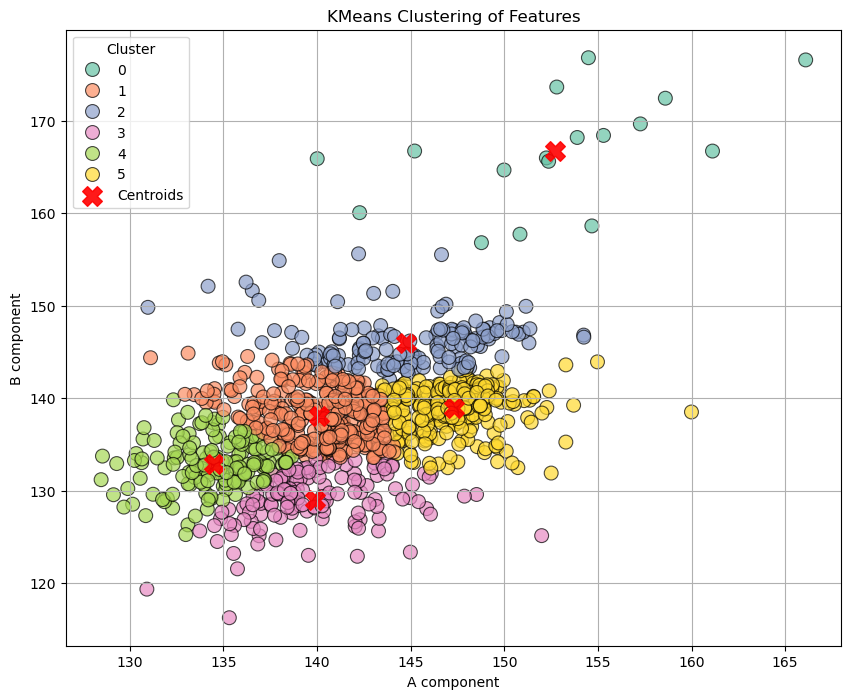

In [13]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='A',
    y='B',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='k',
    alpha=0.7
)

# Plot the cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.9,
    marker='X',
    label='Centroids'
)

# Customize the plot
plt.title('KMeans Clustering of Features')
plt.xlabel('A component')
plt.ylabel('B component')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

In [14]:
cluster_means = df.groupby('cluster')[['A', 'B']].mean().reset_index()
cluster_max = df.groupby('cluster')[['A', 'B']].max().reset_index()
cluster_min = df.groupby('cluster')[['A', 'B']].min().reset_index()

In [15]:
cluster_means.columns = ['cluster', 'A_mean', 'B_mean']
cluster_max.columns = ['cluster', 'A_max', 'B_max']
cluster_min.columns = ['cluster', 'A_min', 'B_min']

In [16]:
combined_cluster_df = pd.merge(cluster_means, cluster_max, on='cluster')
combined_cluster_df = pd.merge(combined_cluster_df, cluster_min, on='cluster')

In [17]:
combined_cluster_df

,cluster,A_mean,B_mean,A_max,B_max,A_min,B_min
0,0,152.700783,166.727519,166.091196,176.800271,140.008557,156.802893
1,1,140.132966,138.105535,144.108250,144.857161,131.108378,133.571484
2,2,144.723430,146.001371,154.243821,155.597622,130.966851,142.028687
3,3,139.875675,128.972124,151.992349,133.406279,130.911204,116.254410
4,4,134.524934,132.903999,138.657981,139.818524,128.468856,125.242822
5,5,147.323413,138.888577,159.992283,143.917336,143.485183,131.894294


In [18]:
def lab_to_rgb(l, a, b):
    # Create a 1x1 LAB image
    lab_color = np.uint8([[[l, a, b]]])
    # Convert LAB to BGR
    bgr_color = cv2.cvtColor(lab_color, cv2.COLOR_LAB2BGR)
    # Convert BGR to RGB
    rgb_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2RGB)
    # Flatten the array
    rgb_color = rgb_color.flatten()
    return rgb_color

In [19]:
cluster_means_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_mean'], x['B_mean'], overall_L_mean), axis=1)
cluster_max_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_max'], x['B_max'], overall_L_mean), axis=1)
cluster_min_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_min'], x['B_min'], overall_L_mean), axis=1)

combined_cluster_df['RGB_mean'] = cluster_means_rgb
combined_cluster_df['RGB_max'] = cluster_max_rgb
combined_cluster_df['RGB_min'] = cluster_min_rgb

In [20]:
combined_cluster_df

,cluster,A_mean,B_mean,A_max,B_max,A_min,B_min,RGB_mean,RGB_max,RGB_min
0,0,152.700783,166.727519,166.091196,176.800271,140.008557,156.802893,"[205, 117, 147]","[235, 122, 161]","[176, 113, 134]"
1,1,140.132966,138.105535,144.108250,144.857161,131.108378,133.571484,"[148, 126, 133]","[162, 126, 138]","[130, 120, 124]"
2,2,144.723430,146.001371,154.243821,155.597622,130.966851,142.028687,"[165, 124, 138]","[190, 128, 148]","[144, 113, 123]"
3,3,139.875675,128.972124,151.992349,133.406279,130.911204,116.254410,"[130, 130, 132]","[151, 140, 144]","[97, 127, 123]"
4,4,134.524934,132.903999,138.657981,139.818524,128.468856,125.242822,"[132, 123, 127]","[148, 123, 131]","[113, 121, 121]"
5,5,147.323413,138.888577,159.992283,143.917336,143.485183,131.894294,"[155, 133, 140]","[176, 142, 153]","[139, 133, 136]"


In [21]:
combined_cluster_df.to_csv(f'cluster_colors_{num_clusters}.csv', index=False)

In [22]:
cluster_colors = []

for _, row in cluster_means.iterrows():
    l_mean = overall_L_mean
    a_mean = row['A_mean']
    b_mean = row['B_mean']
    rgb_color = lab_to_rgb(l_mean, a_mean, b_mean)
    cluster_colors.append(rgb_color)

In [23]:
print(overall_L_mean)

127.49523805144655


In [27]:
df

,filename,L,A,B,cluster
0,../dataset_original/all/CC_1000_jpg.rf.6f593c5...,126.557500,138.001792,133.813171,4
1,../dataset_original/all/CC_1001_jpg.rf.be542e9...,130.647988,154.673867,158.614646,0
2,../dataset_original/all/CC_1002_jpg.rf.fe2526e...,128.956030,150.835723,157.720771,0
3,../dataset_original/all/CC_1003_jpg.rf.bf38690...,154.055896,144.610242,135.410100,5
4,../dataset_original/all/CC_1004_jpg.rf.0cdcd2a...,133.910317,148.777134,156.802893,0
...,...,...,...,...,...
1061,../dataset_original/all/CC_979_jpg.rf.7b466250...,127.145356,142.598823,145.126191,2
1062,../dataset_original/all/CC_980_jpg.rf.4691a9b5...,130.860696,137.679888,140.463481,1
1063,../dataset_original/all/CC_98_jpg.rf.b40978788...,102.403054,148.090884,143.837126,2
1064,../dataset_original/all/CC_998_jpg.rf.6f37d21c...,116.406402,131.305322,135.417948,4


In [37]:
# Save images to cluster directories
def copy_images_to_clusters(df, base_output_dir):
    import shutil
    import os

    print(f"Base output directory: {base_output_dir}")
    os.makedirs(base_output_dir, exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Copying images"):
        source_path = row['filename']
        cluster = row['cluster']
        
        cluster_dir = os.path.join(base_output_dir, f"cluster_{cluster}")
        os.makedirs(cluster_dir, exist_ok=True)
        
        filename = os.path.basename(source_path)
        dest_path = os.path.join(cluster_dir, filename)
        
        try:
            shutil.copy2(source_path, dest_path)
        except Exception as e:
            print(f"Error copying file: {e}")

In [39]:
base_output_dir = f"clusters/{num_clusters}-clusters"
copy_images_to_clusters(df, base_output_dir)

Base output directory: clusters/6-clusters


Copying images: 100%|██████████| 1066/1066 [00:00<00:00, 1939.41it/s]


In [41]:
def find_optimal_clusters(X, max_clusters=10):
    
    # Calculate WCSS for different numbers of clusters
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_clusters + 1), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: User

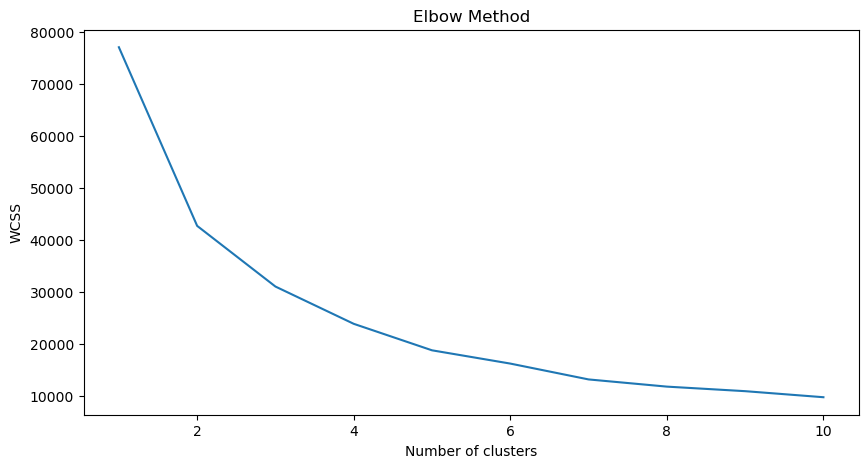

In [42]:
find_optimal_clusters(X)